<a href="https://colab.research.google.com/github/DevLuce/ML_Study_Lab/blob/main/multi_class_classification_of_handwritten_digits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2017 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # 신경망으로 필기 입력된 숫자 분류하기

 ![img](https://www.tensorflow.org/images/MNIST.png)

 **학습 목표:**
  * 선형 모델과 신경망을 모두 학습시켜 기존 [MNIST](http://yann.lecun.com/exdb/mnist/) 데이터 세트의 필기 입력된 숫자를 분류한다
  * 선형 모델과 신경망 분류 모델의 성능을 비교한다
  * 신경망 히든 레이어의 가중치를 시각화한다

 이번 목표는 각각의 입력 이미지를 올바른 숫자에 매핑하는 것입니다. 몇 개의 히든 레이어를 포함하며 소프트맥스 레이어가 맨 위에서 최우수 클래스를 선택하는 NN을 만들어 보겠습니다.

 ## 설정

우선 데이터 세트를 다운로드하고, 텐서플로우 및 기타 유틸리티 모듈을 import로 불러오고, 데이터를 *pandas* `DataFrame`에 로드합니다. 이 데이터는 원본 MNIST 학습 데이터에서 20,000개 행을 무작위로 추출한 샘플입니다.

In [1]:
from __future__ import print_function

import glob
import math
import os

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

mnist_dataframe = pd.read_csv(
  "https://download.mlcc.google.com/mledu-datasets/mnist_train_small.csv",
  sep=",",
  header=None)

# Use just the first 10,000 records for training/validation.
mnist_dataframe = mnist_dataframe.head(10000)

mnist_dataframe = mnist_dataframe.reindex(np.random.permutation(mnist_dataframe.index))
mnist_dataframe.head()

TensorFlow 1.x selected.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
6776,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2618,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
374,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1677,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8212,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


 첫 번째 열은 클래스 라벨을 포함합니다. 나머지 열은 특성 값을 포함하며, `28×28=784`개 픽셀 값마다 각각 하나의 특성 값이 됩니다.  이 784개의 픽셀 값은 대부분 0이지만, 1분 정도 시간을 들여 모두 0은 아니라는 것을 확인하시기 바랍니다.

 ![img](https://www.tensorflow.org/images/MNIST-Matrix.png)

 이러한 예는 비교적 해상도가 낮고 대비가 높은 필기 입력 숫자입니다. `0-9` 범위의 숫자 10개가 각각 표현되었으며 가능한 각 숫자에 고유한 클라스 라벨이 지정됩니다. 따라서 이 문제는 10개 클래스를 대상으로 하는 다중 클래스 분류 문제입니다.

이제 라벨과 특성을 해석하고 몇 가지 예를 살펴보겠습니다. 이 데이터 세트에는 헤더 행이 없지만 `loc`를 사용하여 원래 위치를 기준으로 열을 추출할 수 있습니다.

In [2]:
def parse_labels_and_features(dataset):
  """Extracts labels and features.
  
  This is a good place to scale or transform the features if needed.
  
  Args:
    dataset: A Pandas `Dataframe`, containing the label on the first column and
      monochrome pixel values on the remaining columns, in row major order.
  Returns:
    A `tuple` `(labels, features)`:
      labels: A Pandas `Series`.
      features: A Pandas `DataFrame`.
  """
  labels = dataset[0]

  # DataFrame.loc index ranges are inclusive at both ends.
  features = dataset.loc[:,1:784]
  # Scale the data to [0, 1] by dividing out the max value, 255.
  features = features / 255

  return labels, features

In [3]:
training_targets, training_examples = parse_labels_and_features(mnist_dataframe[:7500])
training_examples.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
count,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,...,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0,7500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.8,1.0,0.8,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.6,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,1.0,1.0,0.9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
validation_targets, validation_examples = parse_labels_and_features(mnist_dataframe[7500:10000])
validation_examples.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
count,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,...,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.3,0.8,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.5,0.0,0.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.6,1.0,1.0,0.8,0.2,1.0,0.2,0.0,0.0,0.0,0.0


 무작위로 선택한 예 및 해당 라벨을 표시합니다.

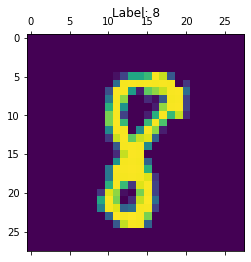

In [5]:
rand_example = np.random.choice(training_examples.index)
_, ax = plt.subplots()
ax.matshow(training_examples.loc[rand_example].values.reshape(28, 28))
ax.set_title("Label: %i" % training_targets.loc[rand_example])
ax.grid(False)

 ## 작업 1: MNIST용 선형 모델 구축

우선 비교 기준이 될 모델을 만듭니다. `LinearClassifier`는 *k*개 클래스마다 하나씩 *k*개의 일대다 분류자 집합을 제공합니다.

이 작업에서는 정확성을 보고하고 시간별 로그 손실을 도식화할 뿐 아니라 [**혼동행렬**](https://en.wikipedia.org/wiki/Confusion_matrix)도 표시합니다. 혼동행렬은 다른 클래스로 잘못 분류된 클래스를 보여줍니다. 서로 혼동하기 쉬운 숫자는 무엇일까요?

또한 `log_loss` 함수를 사용하여 모델의 오차를 추적합니다. 이 함수는 학습에 사용되는 `LinearClassifier` 내장 손실 함수와 다르므로 주의하시기 바랍니다.

In [6]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  
  # There are 784 pixels in each image. 
  return set([tf.feature_column.numeric_column('pixels', shape=784)])

 여기에서는 학습과 예측의 입력 함수를 서로 다르게 만들겠습니다. 각각 `create_training_input_fn()` 및 `create_predict_input_fn()`에 중첩시키고 이러한 함수를 호출할 때 반환되는 해당 `_input_fn`을 `.train()` 및 `.predict()` 호출에 전달하면 됩니다.

In [7]:
def create_training_input_fn(features, labels, batch_size, num_epochs=None, shuffle=True):
  """A custom input_fn for sending MNIST data to the estimator for training.

  Args:
    features: The training features.
    labels: The training labels.
    batch_size: Batch size to use during training.

  Returns:
    A function that returns batches of training features and labels during
    training.
  """
  def _input_fn(num_epochs=None, shuffle=True):
    # Input pipelines are reset with each call to .train(). To ensure model
    # gets a good sampling of data, even when number of steps is small, we 
    # shuffle all the data before creating the Dataset object
    idx = np.random.permutation(features.index)
    raw_features = {"pixels":features.reindex(idx)}
    raw_targets = np.array(labels[idx])
   
    ds = Dataset.from_tensor_slices((raw_features,raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

In [8]:
def create_predict_input_fn(features, labels, batch_size):
  """A custom input_fn for sending mnist data to the estimator for predictions.

  Args:
    features: The features to base predictions on.
    labels: The labels of the prediction examples.

  Returns:
    A function that returns features and labels for predictions.
  """
  def _input_fn():
    raw_features = {"pixels": features.values}
    raw_targets = np.array(labels)
    
    ds = Dataset.from_tensor_slices((raw_features, raw_targets)) # warning: 2GB limit
    ds = ds.batch(batch_size)
    
        
    # Return the next batch of data.
    feature_batch, label_batch = ds.make_one_shot_iterator().get_next()
    return feature_batch, label_batch

  return _input_fn

In [9]:
def train_linear_classification_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear classification model for the MNIST digits dataset.
  
  In addition to training, this function also prints training progress information,
  a plot of the training and validation loss over time, and a confusion
  matrix.
  
  Args:
    learning_rate: A `float`, the learning rate to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing the training features.
    training_targets: A `DataFrame` containing the training labels.
    validation_examples: A `DataFrame` containing the validation features.
    validation_targets: A `DataFrame` containing the validation labels.
      
  Returns:
    The trained `LinearClassifier` object.
  """

  periods = 10

  steps_per_period = steps / periods  
  # Create the input functions.
  predict_training_input_fn = create_predict_input_fn(
    training_examples, training_targets, batch_size)
  predict_validation_input_fn = create_predict_input_fn(
    validation_examples, validation_targets, batch_size)
  training_input_fn = create_training_input_fn(
    training_examples, training_targets, batch_size)
  
  # Create a LinearClassifier object.
  my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  classifier = tf.estimator.LinearClassifier(
      feature_columns=construct_feature_columns(),
      n_classes=10,
      optimizer=my_optimizer,
      config=tf.estimator.RunConfig(keep_checkpoint_max=1)
  )

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss error (on validation data):")
  training_errors = []
  validation_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
  
    # Take a break and compute probabilities.
    training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
    training_probabilities = np.array([item['probabilities'] for item in training_predictions])
    training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
    training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)
        
    validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
    validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
    validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
    validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)    
    
    # Compute training and validation errors.
    training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
    validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, validation_log_loss))
    # Add the loss metrics from this period to our list.
    training_errors.append(training_log_loss)
    validation_errors.append(validation_log_loss)
  print("Model training finished.")
  # Remove event files to save disk space.
  _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
  
  # Calculate final predictions (not probabilities, as above).
  final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
  final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
  
  
  accuracy = metrics.accuracy_score(validation_targets, final_predictions)
  print("Final accuracy (on validation data): %0.2f" % accuracy)

  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.plot(training_errors, label="training")
  plt.plot(validation_errors, label="validation")
  plt.legend()
  plt.show()
  
  # Output a plot of the confusion matrix.
  cm = metrics.confusion_matrix(validation_targets, final_predictions)
  # Normalize the confusion matrix by row (i.e by the number of samples
  # in each class).
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm_normalized, cmap="bone_r")
  ax.set_aspect(1)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()

  return classifier

 **이 형태의 선형 모델로 정확성을 얼마나 높일 수 있는지 5분 동안 확인해 보세요. 이 실습에서는 초매개변수 실험 범위를 배치 크기, 학습률, 단계 수로만 제한합니다.**

정확성이 0.9를 초과하면 실행을 중단하세요.

Training model...
LogLoss error (on validation data):
  period 00 : 20.28
  period 01 : 11.15
  period 02 : 10.32
  period 03 : 8.07
  period 04 : 8.07
  period 05 : 7.00
  period 06 : 6.81
  period 07 : 6.80
  period 08 : 6.76
  period 09 : 5.83
Model training finished.
Final accuracy (on validation data): 0.83


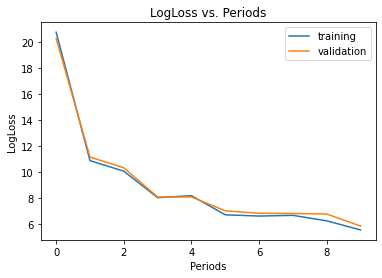

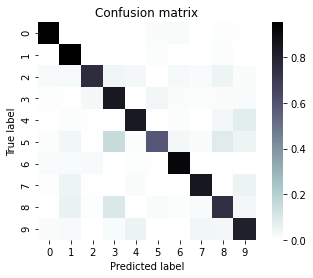

In [10]:
classifier = train_linear_classification_model(
             learning_rate=0.02,
             steps=100,
             batch_size=10,
             training_examples=training_examples,
             training_targets=training_targets,
             validation_examples=validation_examples,
             validation_targets=validation_targets)

 ### 해결 방법

가능한 해결 방법 중 하나를 보려면 아래를 클릭하세요.

 다음은 약 0.9의 정확성을 달성하는 매개변수 세트입니다.

Training model...
LogLoss error (on validation data):
  period 00 : 4.60
  period 01 : 4.52
  period 02 : 4.12
  period 03 : 3.91
  period 04 : 3.79
  period 05 : 3.69
  period 06 : 3.65
  period 07 : 3.63
  period 08 : 3.55
  period 09 : 3.44
Model training finished.
Final accuracy (on validation data): 0.90


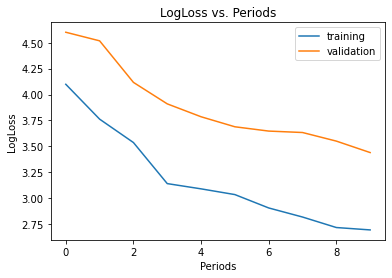

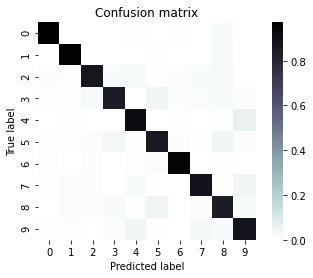

In [11]:
_ = train_linear_classification_model(
    learning_rate=0.03,
    steps=1000,
    batch_size=30,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 ## 작업 2: 선형 분류자를 신경망으로 대체

**위의 LinearClassifier를 [`DNNClassifier`](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier)로 대체하고 0.95 이상의 정확성을 보이는 매개변수 조합을 찾습니다.**

드롭아웃 같은 정규화 방식을 추가로 실험해 볼 수도 있습니다. 이러한 추가 정규화 방식은 `DNNClassifier` 클래스의 설명에 기술되어 있습니다.

In [ ]:
#
# YOUR CODE HERE: Replace the linear classifier with a neural network.
#

 적절한 모델이 확보되었으면 아래에서 로드할 테스트 데이터로 평가하여 검증세트에 대해 과적합되지 않았는지 재확인합니다.


In [12]:
mnist_test_dataframe = pd.read_csv(
  "https://download.mlcc.google.com/mledu-datasets/mnist_test.csv",
  sep=",",
  header=None)

test_targets, test_examples = parse_labels_and_features(mnist_test_dataframe)
test_examples.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.9,0.6,0.9,0.8,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#
# YOUR CODE HERE: Calculate accuracy on the test set.
#

 ### 해결 방법

가능한 해결 방법을 보려면 아래를 클릭하세요.

 아래 코드는 원래의 `LinearClassifer` 학습 코드와 거의 동일하지만, 차이점은 히든 유닛에 대한 초매개변수와 같은 NN 전용 구성이 포함되어 있다는 점입니다.

In [13]:
def train_nn_classification_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a neural network classification model for the MNIST digits dataset.
  
  In addition to training, this function also prints training progress information,
  a plot of the training and validation loss over time, as well as a confusion
  matrix.
  
  Args:
    learning_rate: A `float`, the learning rate to use.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    hidden_units: A `list` of int values, specifying the number of neurons in each layer.
    training_examples: A `DataFrame` containing the training features.
    training_targets: A `DataFrame` containing the training labels.
    validation_examples: A `DataFrame` containing the validation features.
    validation_targets: A `DataFrame` containing the validation labels.
      
  Returns:
    The trained `DNNClassifier` object.
  """

  periods = 10
  # Caution: input pipelines are reset with each call to train. 
  # If the number of steps is small, your model may never see most of the data.  
  # So with multiple `.train` calls like this you may want to control the length 
  # of training with num_epochs passed to the input_fn. Or, you can do a really-big shuffle, 
  # or since it's in-memory data, shuffle all the data in the `input_fn`.
  steps_per_period = steps / periods  
  # Create the input functions.
  predict_training_input_fn = create_predict_input_fn(
    training_examples, training_targets, batch_size)
  predict_validation_input_fn = create_predict_input_fn(
    validation_examples, validation_targets, batch_size)
  training_input_fn = create_training_input_fn(
    training_examples, training_targets, batch_size)
  
  # Create the input functions.
  predict_training_input_fn = create_predict_input_fn(
    training_examples, training_targets, batch_size)
  predict_validation_input_fn = create_predict_input_fn(
    validation_examples, validation_targets, batch_size)
  training_input_fn = create_training_input_fn(
    training_examples, training_targets, batch_size)
  
  # Create feature columns.
  feature_columns = [tf.feature_column.numeric_column('pixels', shape=784)]

  # Create a DNNClassifier object.
  my_optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  classifier = tf.estimator.DNNClassifier(
      feature_columns=feature_columns,
      n_classes=10,
      hidden_units=hidden_units,
      optimizer=my_optimizer,
      config=tf.contrib.learn.RunConfig(keep_checkpoint_max=1)
  )

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("LogLoss error (on validation data):")
  training_errors = []
  validation_errors = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
  
    # Take a break and compute probabilities.
    training_predictions = list(classifier.predict(input_fn=predict_training_input_fn))
    training_probabilities = np.array([item['probabilities'] for item in training_predictions])
    training_pred_class_id = np.array([item['class_ids'][0] for item in training_predictions])
    training_pred_one_hot = tf.keras.utils.to_categorical(training_pred_class_id,10)
        
    validation_predictions = list(classifier.predict(input_fn=predict_validation_input_fn))
    validation_probabilities = np.array([item['probabilities'] for item in validation_predictions])    
    validation_pred_class_id = np.array([item['class_ids'][0] for item in validation_predictions])
    validation_pred_one_hot = tf.keras.utils.to_categorical(validation_pred_class_id,10)    
    
    # Compute training and validation errors.
    training_log_loss = metrics.log_loss(training_targets, training_pred_one_hot)
    validation_log_loss = metrics.log_loss(validation_targets, validation_pred_one_hot)
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, validation_log_loss))
    # Add the loss metrics from this period to our list.
    training_errors.append(training_log_loss)
    validation_errors.append(validation_log_loss)
  print("Model training finished.")
  # Remove event files to save disk space.
  _ = map(os.remove, glob.glob(os.path.join(classifier.model_dir, 'events.out.tfevents*')))
  
  # Calculate final predictions (not probabilities, as above).
  final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
  final_predictions = np.array([item['class_ids'][0] for item in final_predictions])
  
  
  accuracy = metrics.accuracy_score(validation_targets, final_predictions)
  print("Final accuracy (on validation data): %0.2f" % accuracy)

  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.plot(training_errors, label="training")
  plt.plot(validation_errors, label="validation")
  plt.legend()
  plt.show()
  
  # Output a plot of the confusion matrix.
  cm = metrics.confusion_matrix(validation_targets, final_predictions)
  # Normalize the confusion matrix by row (i.e by the number of samples
  # in each class).
  cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
  ax = sns.heatmap(cm_normalized, cmap="bone_r")
  ax.set_aspect(1)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")
  plt.show()

  return classifier

Training model...
LogLoss error (on validation data):
  period 00 : 5.25
  period 01 : 4.17
  period 02 : 3.85
  period 03 : 2.54
  period 04 : 2.68
  period 05 : 2.51
  period 06 : 2.54
  period 07 : 2.06
  period 08 : 1.89
  period 09 : 2.02
Model training finished.
Final accuracy (on validation data): 0.94


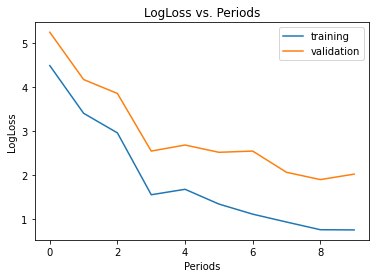

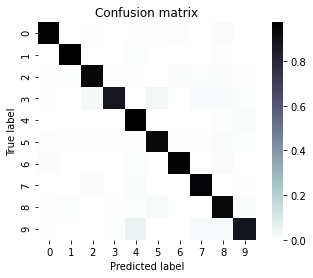

In [14]:
classifier = train_nn_classification_model(
    learning_rate=0.05,
    steps=1000,
    batch_size=30,
    hidden_units=[100, 100],
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

 다음으로는 테스트 세트로 정확성을 검증합니다.

In [15]:
mnist_test_dataframe = pd.read_csv(
  "https://download.mlcc.google.com/mledu-datasets/mnist_test.csv",
  sep=",",
  header=None)

test_targets, test_examples = parse_labels_and_features(mnist_test_dataframe)
test_examples.describe()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,...,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.1,0.1,0.1,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.9,0.6,0.9,0.8,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
predict_test_input_fn = create_predict_input_fn(
    test_examples, test_targets, batch_size=100)

test_predictions = classifier.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['class_ids'][0] for item in test_predictions])
  
accuracy = metrics.accuracy_score(test_targets, test_predictions)
print("Accuracy on test data: %0.2f" % accuracy)

Accuracy on test data: 0.95


 ## 작업 3: 첫 번째 히든 레이어의 가중치 시각화

몇 분 정도 시간을 들여 신경망을 살펴보면서 `weights_` 특성에 액세스하여 무엇을 학습했는지 확인해 보겠습니다.

모델의 입력 레이어는 `28×28` 픽셀 입력 이미지에 해당하는 `784`개의 가중치를 갖습니다. 첫 번째 히든 레이어는 `784×N`개의 가중치를 갖는데, 여기에서 `N`은 해당 레이어의 노드 수입니다. `N`개의 `1×784` 가중치 배열 각각을 `28×28` 크기의 배열 `N` 개로 *재구성(reshape)*하면 이러한 가중치를 `28×28` 이미지로 되돌릴 수 있습니다.

다음 셀을 실행하여 가중치를 도식화하세요. 이 셀을 실행하려면 "classifier"라는 `DNNClassifier`가 이미 학습된 상태여야 합니다.

['dnn/hiddenlayer_0/bias', 'dnn/hiddenlayer_0/bias/t_0/Adagrad', 'dnn/hiddenlayer_0/kernel', 'dnn/hiddenlayer_0/kernel/t_0/Adagrad', 'dnn/hiddenlayer_1/bias', 'dnn/hiddenlayer_1/bias/t_0/Adagrad', 'dnn/hiddenlayer_1/kernel', 'dnn/hiddenlayer_1/kernel/t_0/Adagrad', 'dnn/logits/bias', 'dnn/logits/bias/t_0/Adagrad', 'dnn/logits/kernel', 'dnn/logits/kernel/t_0/Adagrad', 'global_step']
weights0 shape: (784, 100)


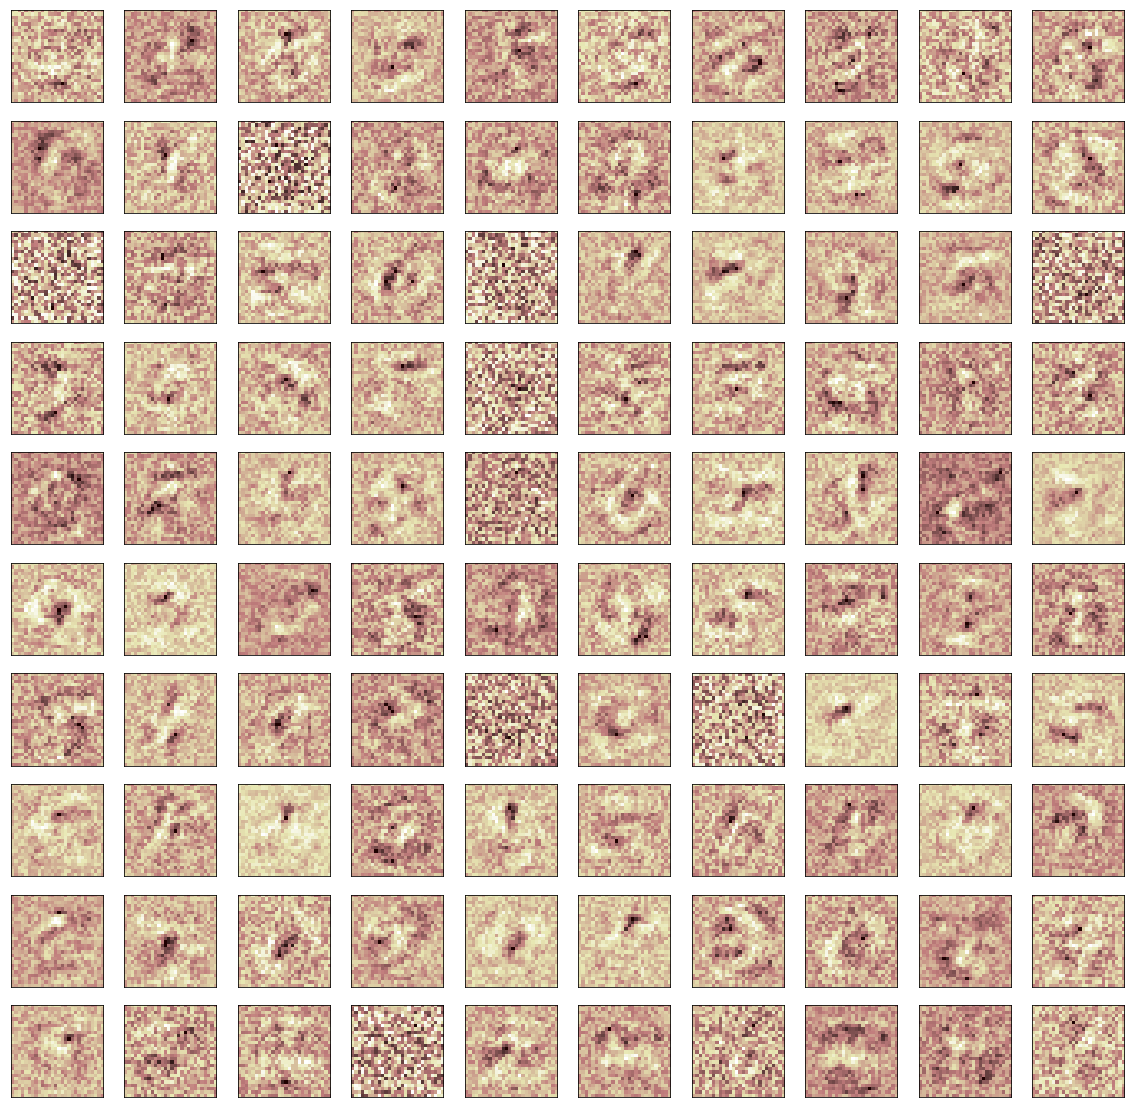

In [17]:
print(classifier.get_variable_names())

weights0 = classifier.get_variable_value("dnn/hiddenlayer_0/kernel")

print("weights0 shape:", weights0.shape)

num_nodes = weights0.shape[1]
num_rows = int(math.ceil(num_nodes / 10.0))
fig, axes = plt.subplots(num_rows, 10, figsize=(20, 2 * num_rows))
for coef, ax in zip(weights0.T, axes.ravel()):
    # Weights in coef is reshaped from 1x784 to 28x28.
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.pink)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

 신경망의 첫 번째 히든 레이어는 비교적 저수준인 특성을 모델링해야 하므로 가중치를 시각화해도 알아보기 어려운 형상이나 숫자의 일부만 표시될 가능성이 높습니다. 또한 수렴되지 않았거나 상위 레이어에서 무시하는, 근본적으로 노이즈인 뉴런이 보일 수도 있습니다.

서로 다른 반복 단계에서 학습을 중지하면서 효과를 비교하면 흥미로울 수 있습니다.

**분류자를 각각 10단계, 100단계, 1000단계 동안 학습시키고 이 시각화를 다시 실행해 보세요.**

여러 가지 수렴 레벨에서 시각적으로 어떠한 차이점이 보이나요?